In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [9]:
pwd

'/Users/tarunagrawal'

In [13]:
DIRECTORY = r"Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [14]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [15]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [16]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, 
                                stratify=labels, random_state=42)

In [18]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [19]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
2022-01-23 15:10:23.479607: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-23 15:10:23.481191: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


9412608/9406464 [==============================] - 4s 0us/step


In [20]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [21]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [22]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [23]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [24]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...


2022-01-23 15:11:43.637950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 96
2022-01-23 15:11:53.406732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 63 of 96
2022-01-23 15:12:03.380126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 96
2022-01-23 15:12:03.658272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


Train for 95 steps, validate on 767 samples
Epoch 1/20


2022-01-23 15:12:16.960272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 96
2022-01-23 15:12:26.998804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 96
2022-01-23 15:12:35.431681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 273s 3s/step - loss: 0.5616 - accuracy: 0.7116 - val_loss: 0.3063 - val_accuracy: 0.9103
Epoch 2/20


2022-01-23 15:16:46.852991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 96
2022-01-23 15:16:57.017470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 66 of 96
2022-01-23 15:17:06.141775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 269s 3s/step - loss: 0.3188 - accuracy: 0.8711 - val_loss: 0.2224 - val_accuracy: 0.9185
Epoch 3/20


2022-01-23 15:21:15.907948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:21:25.883445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 65 of 96
2022-01-23 15:21:35.436648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 270s 3s/step - loss: 0.2275 - accuracy: 0.9179 - val_loss: 0.1931 - val_accuracy: 0.9253
Epoch 4/20


2022-01-23 15:25:45.421377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:25:55.543688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 65 of 96
2022-01-23 15:26:04.921549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 272s 3s/step - loss: 0.1942 - accuracy: 0.9229 - val_loss: 0.2370 - val_accuracy: 0.8954
Epoch 5/20


2022-01-23 15:30:17.364498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:30:27.534703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 65 of 96
2022-01-23 15:30:36.958704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 270s 3s/step - loss: 0.1665 - accuracy: 0.9403 - val_loss: 0.1892 - val_accuracy: 0.9090
Epoch 6/20


2022-01-23 15:34:47.224337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 96
2022-01-23 15:34:57.253696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 63 of 96
2022-01-23 15:35:07.303031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 96
2022-01-23 15:35:07.565406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 271s 3s/step - loss: 0.1646 - accuracy: 0.9370 - val_loss: 0.2146 - val_accuracy: 0.9076
Epoch 7/20


2022-01-23 15:39:18.827502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:39:28.773456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 15:39:38.622632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 274s 3s/step - loss: 0.1448 - accuracy: 0.9443 - val_loss: 0.1975 - val_accuracy: 0.9144
Epoch 8/20


2022-01-23 15:43:53.222666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:44:03.077498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 15:44:13.071516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 273s 3s/step - loss: 0.1402 - accuracy: 0.9476 - val_loss: 0.2455 - val_accuracy: 0.9049
Epoch 9/20


2022-01-23 15:48:26.549011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:48:36.634929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 15:48:46.568975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 96
2022-01-23 15:48:46.890185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 276s 3s/step - loss: 0.1254 - accuracy: 0.9502 - val_loss: 0.2774 - val_accuracy: 0.8995
Epoch 10/20


2022-01-23 15:53:02.671346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 15:53:12.688062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 15:53:22.561795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 273s 3s/step - loss: 0.1238 - accuracy: 0.9595 - val_loss: 0.1805 - val_accuracy: 0.9307
Epoch 11/20


2022-01-23 15:57:36.146510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 96
2022-01-23 15:57:46.192330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 63 of 96
2022-01-23 15:57:56.124222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 96
2022-01-23 15:57:56.386825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 270s 3s/step - loss: 0.1135 - accuracy: 0.9568 - val_loss: 0.3053 - val_accuracy: 0.8954
Epoch 12/20


2022-01-23 16:02:06.096944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 16:02:16.105042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 16:02:25.835401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 270s 3s/step - loss: 0.1051 - accuracy: 0.9637 - val_loss: 0.2206 - val_accuracy: 0.9158
Epoch 13/20


2022-01-23 16:06:35.901105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 16:06:46.083886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 65 of 96
2022-01-23 16:06:55.542912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 309s 3s/step - loss: 0.1135 - accuracy: 0.9595 - val_loss: 0.1500 - val_accuracy: 0.9375
Epoch 14/20


2022-01-23 16:11:45.408458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 16:11:55.506330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 63 of 96
2022-01-23 16:12:05.537110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 96
2022-01-23 16:12:05.794992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 287s 3s/step - loss: 0.1009 - accuracy: 0.9661 - val_loss: 0.1924 - val_accuracy: 0.9293
Epoch 15/20


2022-01-23 16:16:32.523764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 96
2022-01-23 16:16:42.466219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 52 of 96
2022-01-23 16:16:52.320664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 79 of 96
2022-01-23 16:16:58.214312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 340s 4s/step - loss: 0.1050 - accuracy: 0.9614 - val_loss: 0.1593 - val_accuracy: 0.9334
Epoch 16/20


2022-01-23 16:22:12.182496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 96
2022-01-23 16:22:22.356209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 96
2022-01-23 16:22:32.246605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 76 of 96
2022-01-23 16:22:40.058824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 319s 3s/step - loss: 0.0934 - accuracy: 0.9631 - val_loss: 0.1708 - val_accuracy: 0.9348
Epoch 17/20


2022-01-23 16:27:31.391862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 96
2022-01-23 16:27:41.331531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 62 of 96
2022-01-23 16:27:51.506674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 94 of 96
2022-01-23 16:27:52.124454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 280s 3s/step - loss: 0.0932 - accuracy: 0.9677 - val_loss: 0.2503 - val_accuracy: 0.9171
Epoch 18/20


2022-01-23 16:32:11.546640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 16:32:21.588735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 64 of 96
2022-01-23 16:32:31.598444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 277s 3s/step - loss: 0.1046 - accuracy: 0.9641 - val_loss: 0.1966 - val_accuracy: 0.9280
Epoch 19/20


2022-01-23 16:36:48.909405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 96
2022-01-23 16:36:58.746199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 62 of 96
2022-01-23 16:37:08.792626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 94 of 96
2022-01-23 16:37:09.375182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 277s 3s/step - loss: 0.0871 - accuracy: 0.9661 - val_loss: 0.1942 - val_accuracy: 0.9280
Epoch 20/20


2022-01-23 16:41:26.255665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 96
2022-01-23 16:41:36.249600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 62 of 96
2022-01-23 16:41:46.154302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 94 of 96
2022-01-23 16:41:46.763138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


95/95 [==============================] - 284s 3s/step - loss: 0.0922 - accuracy: 0.9667 - val_loss: 0.2145 - val_accuracy: 0.9280


In [25]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [26]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [27]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.86      0.92       383
without_mask       0.88      1.00      0.93       384

    accuracy                           0.93       767
   macro avg       0.94      0.93      0.93       767
weighted avg       0.94      0.93      0.93       767



In [28]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


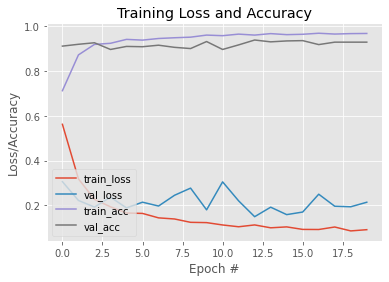

In [29]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")